In [23]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [24]:
import torch
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
from collections import Counter
import collections

from sklearn.model_selection import train_test_split

from sklearn.ensemble import IsolationForest
from sklearn.neighbors import LocalOutlierFactor
from sklearn.linear_model import SGDOneClassSVM
from sklearn.svm import OneClassSVM

from sklearn.preprocessing import OneHotEncoder, RobustScaler
from sklearn.metrics import roc_auc_score, accuracy_score, confusion_matrix, auc
from sklearn.metrics import precision_recall_fscore_support, precision_recall_curve, f1_score

pd.options.mode.chained_assignment = None 

In [34]:
def load_train_year(year):
    if year <= 2010:
        df = pd.read_csv(f'../datasets/kyoto-2016/logbins_labels_dupskyoto-2016_{year}_subset_300000.csv', 
                          engine="python", index_col=[0])
    else:
        sys.exit(-1)
    df = df.reset_index(drop=True)
    return df.sample(frac=0.05).dropna()

def load_test_year(year):
    if year <= 2010:
        df = pd.read_csv(f'../datasets/kyoto-2016/logbins_labels_dupskyoto-2016_{year}_subset_300000_valid.csv', 
                              engine="python", index_col=[0])
    else:
        df = pd.read_csv(f'../datasets/kyoto-2016/logbins_labels_dupskyoto-2016_{year}_subset_300000.csv', 
                              engine="python", index_col=[0])
    df = df.reset_index(drop=True)
    return df.sample(frac=0.05).dropna()


# categorical columns: "0", "1", "2", "3"
# additional features columns: 
# # "14" - timestamp
# # "15", "16", "17" - labels
# # "19" - additional
# label column: "18"

def rename_columns(df):
    categorical_cols = ["0", "1", "2", "3"]
    numerical_cols = ["4", "5", "6", "7", "8", "9", "10", "11", "12"]
    additional_cols = ["14", "15", "16", "17", "19"]
    label_col = ["18"]

    new_names = []
    for col_name in df.columns.values:
        if col_name in numerical_cols:
            new_names.append((col_name, "num_" + col_name))
        elif col_name in categorical_cols:
            new_names.append((col_name, "cat_" + col_name))
        elif col_name in additional_cols:
            new_names.append((col_name, "bonus_" + col_name))
        elif col_name in label_col:
            new_names.append((col_name, "label"))
        else:
            new_names.append((col_name, col_name))
    df.rename(columns=dict(new_names), inplace=True)
    return df

def preprocess(df, enc=None):
    if not enc:
        enc = OneHotEncoder(handle_unknown='ignore')
        enc.fit(df.loc[:,['cat_' in i for i in df.columns]])
    
    num_cat_features = enc.transform(df.loc[:,['cat_' in i for i in df.columns]]).toarray()

    df_catnum = pd.DataFrame(num_cat_features)
    df_catnum = df_catnum.add_prefix('catnum_')

    df.reset_index(drop=True)
    df_new = pd.concat([df,  df_catnum], axis=1)
    
    
    filter_clear = df_new["label"] == 1
    filter_infected = df_new["label"] < 0
    df_new["label"][filter_clear] = 0
    df_new["label"][filter_infected] = 1

    return df_new, enc


def print_results(labels, preds, text="?", normalize="true", th=0.5):
    # percent = int(sum(labels))*100/len(labels)
#     print("Anomalies: %.2f%% (%d/%d)" % (percent, int(sum(labels)), len(labels)))
#     print(confusion_matrix(labels, np.array(preds)>=th, normalize=normalize))
#     ConfusionMatrixDisplay.from_predictions(labels, np.array(preds)>=th, normalize=normalize)
    
    precision_anom, recall_anom, th_anom = precision_recall_curve(labels, preds, pos_label=1)
#     print("anom", precision_anom, recall_anom, th_anom)
    precision_norm, recall_norm, th_norm = precision_recall_curve(labels, 1-np.array(preds), pos_label=0)
    
    prec, recall, _, _ = precision_recall_fscore_support(labels, np.array(preds)>=th)
    f1_norm, f1_anom = f1_score(labels, np.array(preds)>=th, average=None)
    
    # Use AUC function to calculate the area under the curve of precision recall curve
    pr_auc_norm = auc(recall_norm, precision_norm)
    pr_auc_anom = auc(recall_anom, precision_anom)
    
    roc_auc = roc_auc_score(labels, preds)
    
#     print("\nRecall-norm    %.2f%% | Recall-anom    %.2f%%" % (recall[0]*100, recall[1]*100))
#     print("Precision-norm %.2f%% | Precision-anom %.2f%%" % (prec[0]*100, prec[1]*100))
#     print("F1-norm        %.2f%% | F1-anom        %.2f%%" % (f1_norm*100, f1_anom*100))    
    print("[%s] ROC-AUC     %.2f%% | PR-AUC-norm    %.2f%% | PR-AUC-anom    %.2f%%" % (text, roc_auc*100, pr_auc_norm*100, pr_auc_anom*100))
    global_roc.append(roc_auc*100)
    global_pr_norm.append(pr_auc_norm*100)
    global_pr_anom.append(pr_auc_anom*100)
#     print("pt tabel")
#     print("%.2f\n%.2f\n%.2f" % (roc_auc*100, pr_auc_norm*100, pr_auc_anom*100))
    return f1_anom, pr_auc_anom

In [35]:
def get_train(train_years):
    dfs = []

    for year in train_years: 
        df_year = load_train_year(year)
        dfs.append(df_year)
        print(year, df_year[df_year["18"] == 1].shape)
    #     print(year, df_year.shape)
    df_all_years = pd.concat(dfs, ignore_index=True)
    df_all_years = rename_columns(df_all_years)
    df_new, ohe_enc = preprocess(df_all_years)    


    # split train + val
    X_train, X_val = train_test_split(df_new, test_size=0.001, random_state=0, shuffle=True)

    # prepare for isoforest
    isoforest_cols = df_new.columns.to_numpy()[['num_' in i for i in df_new.columns]]

    X_train_iso_all = X_train[isoforest_cols].to_numpy()
    y_train_iso_all = X_train["label"].to_numpy()

    X_train_clear = X_train[X_train["label"] == 0]
    X_train_iso = X_train_clear[isoforest_cols].to_numpy()

    X_val_iso = X_val[isoforest_cols].to_numpy()
    y_val_iso = X_val["label"].to_numpy()
    return X_train_iso, X_val_iso, y_val_iso, isoforest_cols, ohe_enc

[2006, 2007, 2008] [2006, 2007, 2008]
2006 (2551, 21)
2007 (14994, 21)
2008 (14951, 21)


[Parallel(n_jobs=10)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done   2 out of  10 | elapsed:    2.8s remaining:   11.1s
[Parallel(n_jobs=10)]: Done  10 out of  10 | elapsed:    2.9s finished


Done fitting
[2006] ROC-AUC     17.21% | PR-AUC-norm    37.80% | PR-AUC-anom    30.31%
[2007] ROC-AUC     38.39% | PR-AUC-norm    85.83% | PR-AUC-anom    11.09%
[2008] ROC-AUC     34.44% | PR-AUC-norm    89.40% | PR-AUC-anom    7.25%
[2006, 2007, 2008] [2006, 2007, 2008] 10
17.21	38.39	34.44	
37.80	85.83	89.40	
30.31	11.09	7.25	




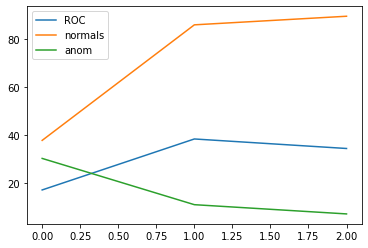

[2006, 2007, 2008] [2006, 2007, 2008]
2006 (2474, 21)
2007 (15028, 21)
2008 (15004, 21)


[Parallel(n_jobs=10)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done   2 out of  10 | elapsed:    2.6s remaining:   10.5s
[Parallel(n_jobs=10)]: Done  10 out of  10 | elapsed:    2.8s finished


Done fitting
[2006] ROC-AUC     21.43% | PR-AUC-norm    38.90% | PR-AUC-anom    32.74%
[2007] ROC-AUC     38.04% | PR-AUC-norm    82.85% | PR-AUC-anom    10.87%
[2008] ROC-AUC     33.98% | PR-AUC-norm    87.71% | PR-AUC-anom    6.80%
[2006, 2007, 2008] [2006, 2007, 2008] 15
21.43	38.04	33.98	
38.90	82.85	87.71	
32.74	10.87	6.80	




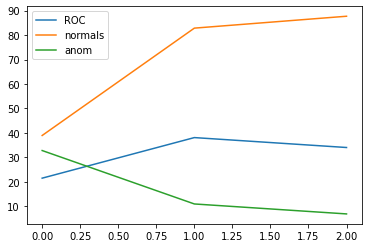

[2006, 2007, 2008] [2006, 2007, 2008]
2006 (2484, 21)
2007 (15040, 21)
2008 (14986, 21)


[Parallel(n_jobs=10)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done   2 out of  10 | elapsed:    2.7s remaining:   10.9s
[Parallel(n_jobs=10)]: Done  10 out of  10 | elapsed:    2.9s finished


Done fitting
[2006] ROC-AUC     14.56% | PR-AUC-norm    37.30% | PR-AUC-anom    29.71%
[2007] ROC-AUC     40.17% | PR-AUC-norm    87.02% | PR-AUC-anom    11.09%
[2008] ROC-AUC     38.74% | PR-AUC-norm    90.48% | PR-AUC-anom    7.84%
[2006, 2007, 2008] [2006, 2007, 2008] 20
14.56	40.17	38.74	
37.30	87.02	90.48	
29.71	11.09	7.84	




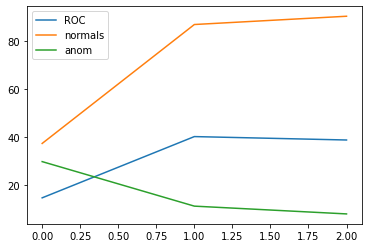

In [39]:
pair_years = []
pair_years.append(([2006, 2007, 2008,], [2006, 2007, 2008, ]))
    
for rs in [10, 15, 20]:
    for train_years, test_years in pair_years:
        global_roc = []
        global_pr_norm = []
        global_pr_anom = []

        print(train_years, test_years)
        X_train_iso, X_val_iso, y_val_iso, isoforest_cols, ohe_enc = get_train(train_years)
        clf = IsolationForest(random_state=rs,
                          n_estimators=101,
                          max_samples=1.0,
                          max_features=1.0,
                          verbose=1,
                          warm_start=False,
                          n_jobs=10)
        clf.fit(X_train_iso)

        del X_train_iso
            
        print("Done fitting")
        for year in test_years:
            df_year = load_test_year(year)
            df_year = rename_columns(df_year)
            df_test, _ = preprocess(df_year, ohe_enc)

            X_test = df_test[isoforest_cols].to_numpy()
            y_test = df_test["label"].to_numpy()

            X_test = np.nan_to_num(X_test)

            predict_test = (-1) * clf.score_samples(X_test)
            predict_test = np.nan_to_num(predict_test, 0)
            y_test = np.nan_to_num(y_test, 0)
            print_results(y_test, predict_test, text=str(year), normalize=None, th=0.35)
            del df_test, df_year, X_test

        print(train_years, test_years, rs)
        for i, year in enumerate(test_years):
            print("%.2f\t" % (global_roc[i]), end = '')
        print("")
        for i, year in enumerate(test_years):
            print("%.2f\t" % (global_pr_norm[i]), end = '')
        print("")

        for i, year in enumerate(test_years):
            print("%.2f\t" % (global_pr_anom[i]), end = '')
        print("\n===================================\n\n")

        plt.plot(global_roc, label='ROC')
        plt.plot(global_pr_norm, label="normals")
        plt.plot(global_pr_anom, label='anom')
        plt.legend()
        plt.show()
